## 1.

*Recogiendo los datos de coronavirus de la página https://ourworldindata.org/coronavirus-source-data* 

A partir de la letra de tu DNI, elige al país que empieza por dicha letra que más fallecidos tenga. Si el país elegido no está entre el top 20 de fallecidos, elige como país España.

En este caso, utilizaremos las columnas:

- Nuevos casos
- Nuevos fallecidos
- Población
- Fallecidos totales
- Casos totales

La fecha debe estar en el índice.

1. Representa todas las columnas en un gráfica con diferentes magnitudes en el eje y para su correcta visualización.

2. Elimina la columna "Población".

3. Entrena los algoritmos de regresión que hemos visto hasta ahora para predecir dos columnas por separado: Nuevos casos y Nuevos fallecidos. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento. ¿Qué error se comete? ¿crees que los algoritmos de ML vistos hasta ahora son buenos para realizar un forecast de una serie temporal viendo los resultados?

4. Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones = 23 y n_repeats = 7 para este ejercicio y solo para la columna "nuevos casos".

In [258]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RepeatedKFold, cross_val_score, train_test_split, learning_curve

In [259]:
df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')

In [260]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN


In [261]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97126 entries, 0 to 97125
Data columns (total 60 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   iso_code                               97126 non-null  object 
 1   continent                              92556 non-null  object 
 2   location                               97126 non-null  object 
 3   date                                   97126 non-null  object 
 4   total_cases                            93791 non-null  float64
 5   new_cases                              93788 non-null  float64
 6   new_cases_smoothed                     92773 non-null  float64
 7   total_deaths                           83715 non-null  float64
 8   new_deaths                             83871 non-null  float64
 9   new_deaths_smoothed                    92773 non-null  float64
 10  total_cases_per_million                93291 non-null  float64
 11  ne

In [262]:
world_continents = ['World', 'Europe', 'South America', 'North America', 'Asia', 'European Union', 'Africa']

In [263]:
search_country_df = df[df.date == '2021-06-20'].sort_values(by='total_deaths', ascending=False)

In [264]:
search_country_df[~search_country_df['location'].isin(world_continents)].head(20)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
92567,USA,North America,United States,2021-06-20,33541887.0,3892.0,11412.000,601824.0,83.0,281.857,...,1.2,151.089,10.79,19.1,24.6,NaN,2.770,78.86,0.926,NaN
12837,BRA,South America,Brazil,2021-06-20,17927928.0,44178.0,73594.571,501825.0,1025.0,2060.571,...,3.4,177.961,8.11,10.1,17.9,NaN,2.200,75.88,0.765,NaN
40660,IND,Asia,India,2021-06-20,29935221.0,53449.0,60687.286,388135.0,1427.0,1975.714,...,21.2,282.280,10.39,1.9,20.6,59.550,0.530,69.66,0.645,NaN
57033,MEX,North America,Mexico,2021-06-20,2477283.0,5542.0,3301.000,231187.0,228.0,148.143,...,2.5,152.783,13.06,6.9,21.4,87.847,1.380,75.05,0.779,NaN
69642,PER,South America,Peru,2021-06-20,2026729.0,3550.0,3300.571,190202.0,269.0,213.429,...,3.5,85.755,5.95,4.8,NaN,NaN,1.600,76.74,0.777,NaN
92051,GBR,Europe,United Kingdom,2021-06-20,4646068.0,9077.0,9184.143,128240.0,6.0,10.286,...,0.2,122.137,4.28,20.0,24.7,NaN,2.540,81.32,0.932,NaN
44231,ITA,Europe,Italy,2021-06-20,4252976.0,881.0,1157.714,127270.0,17.0,38.286,...,2.0,113.151,4.78,19.8,27.8,NaN,3.180,83.51,0.892,NaN
72575,RUS,Europe,Russia,2021-06-20,5255214.0,17367.0,15245.000,127206.0,445.0,413.143,...,0.1,431.297,6.18,23.4,58.3,NaN,8.050,72.58,0.824,NaN
31978,FRA,Europe,France,2021-06-20,5819088.0,1816.0,2396.286,110900.0,14.0,49.571,...,NaN,86.060,4.77,30.1,35.6,NaN,5.980,82.66,0.901,NaN
19241,COL,South America,Colombia,2021-06-20,3945166.0,27818.0,27420.286,99934.0,599.0,593.714,...,4.5,124.240,7.44,4.7,13.5,65.386,1.710,77.29,0.767,NaN


Nos quedamos con Brasil

In [265]:
df = df[df.location == 'Brazil']
df = df.set_index('date')
df = df[['new_cases', 'new_deaths', 'population', 'total_deaths', 'total_cases']]

<AxesSubplot:xlabel='date'>

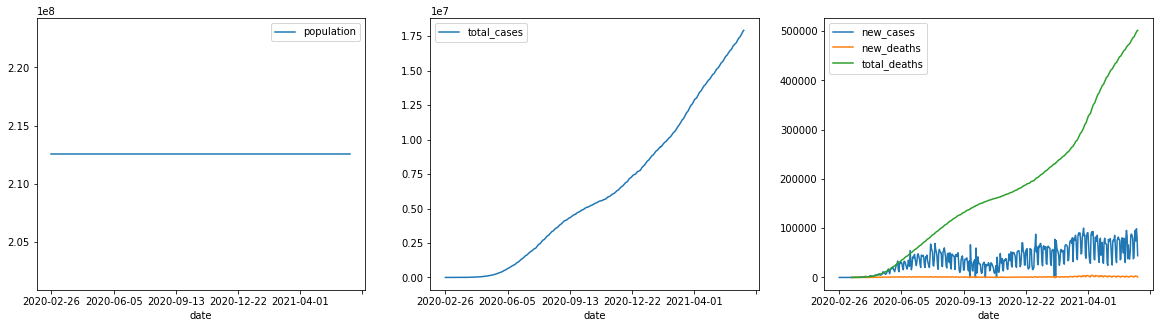

In [266]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
df['population'].plot(ax=ax[0], legend=True)
df['total_cases'].plot(ax=ax[1], legend=True)
df.drop(['population', 'total_cases'], axis=1).plot(ax=ax[2])

In [267]:
df = df.drop('population', axis=1)

Contamos los valores nulos

In [268]:
df.isna().mean()

new_cases       0.00000
new_deaths      0.04158
total_deaths    0.04158
total_cases     0.00000
dtype: float64

In [269]:
df = df.dropna()

In [270]:
df.head()

,new_cases,new_deaths,total_deaths,total_cases
date,,,,
2020-03-17,121.0,1.0,1.0,321.0
2020-03-18,51.0,2.0,3.0,372.0
2020-03-19,249.0,3.0,6.0,621.0
2020-03-20,172.0,5.0,11.0,793.0
2020-03-21,228.0,4.0,15.0,1021.0


In [291]:
df.shape[0] * 0.8

368.8

In [271]:
X = df[['new_deaths', 'total_deaths', 'total_cases']].to_numpy()
target = df['new_cases'].to_numpy()

Entrenamiento

In [272]:
seed = 42

In [273]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=seed)

In [310]:
cv = RepeatedKFold(n_splits=23, n_repeats=7, random_state=seed)

In [311]:
def plot_learning_curve(model, X, y, cv):    
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv)
    plt.plot(train_sizes,np.mean(train_scores,axis=1), label='Train curve')
    plt.plot(train_sizes,np.mean(test_scores,axis=1), label='Validation curve')
    plt.legend()

LinearRegression

Text(0, 0.5, 'Score')

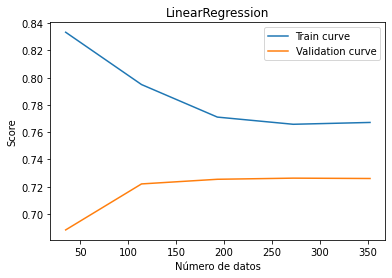

In [276]:
model = LinearRegression()
plot_learning_curve(model, X_train, y_train, cv)
plt.title(model.__class__.__name__)
plt.xlabel('Número de datos')
plt.ylabel('Score')

Text(0, 0.5, 'Score')

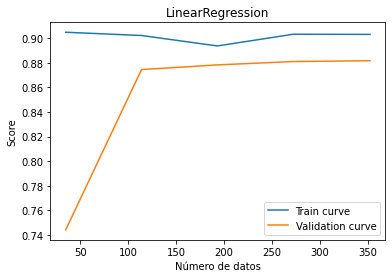

In [277]:
model = LinearRegression()
poly_transform = PolynomialFeatures(degree=2)
X_poly_train = poly_transform.fit_transform(X_train)

plot_learning_curve(model, X_poly_train, y_train, cv)
plt.title(model.__class__.__name__)
plt.xlabel('Número de datos')
plt.ylabel('Score')

Text(0, 0.5, 'Score')

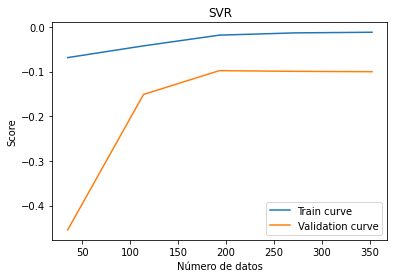

In [278]:
model = SVR()
plot_learning_curve(model, X_train, y_train, cv)
plt.title(model.__class__.__name__)
plt.xlabel('Número de datos')
plt.ylabel('Score')

Text(0, 0.5, 'Score')

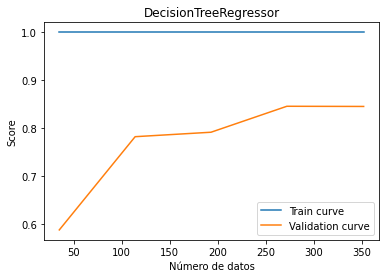

In [279]:
model = DecisionTreeRegressor()
plot_learning_curve(model, X_train, y_train, cv)
plt.title(model.__class__.__name__)
plt.xlabel('Número de datos')
plt.ylabel('Score')

In [306]:
train_sizes 

array([ 35, 114, 193, 272, 352])

In [313]:
cv = RepeatedKFold(n_splits=23, n_repeats=7, random_state=seed)

In [ ]:
for i, (wootrain, wootest) in enumerate(cv.split(X_train)):
    model.train()